### LICENSE PLATE OBJECT DETECTION

Based on https://huggingface.co/datasets/keremberke/license-plate-object-detection

In [205]:
# Install dependencies and libreries
!pip install torchmetrics
!pip install --upgrade --no-cache-dir gdown
!jupyter nbextension enable --py widgetsnbextension

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: ok


In [206]:
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os

import torch
import torchvision
import torchsummary
import torchmetrics
from torch.utils.tensorboard import SummaryWriter
from transformers import AutoFeatureExtractor
from datasets import load_dataset
from PIL import Image, ImageDraw
import torchvision.transforms as transform
# For data augmentation
from torchvision.transforms import Compose, Normalize, RandomResizedCrop, ColorJitter, ToTensor


In [207]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [208]:
torch.backends.cudnn.benchmark = True

In [209]:

data_set = load_dataset( "keremberke/license-plate-object-detection", name="full")
data_set

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 6176
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 1765
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 882
    })
})

In [365]:
def building_dataset(dataset):
    for ds_name in dataset:
        if ds_name == 'train':
            img_id_train = dataset[ds_name][::]['image_id']
            img_train = dataset[ds_name][::]['image']
            objects_train = dataset[ds_name][::]['objects']
        elif  ds_name == 'test':
            img_id_test = dataset[ds_name][::]['image_id']
            img_test = dataset[ds_name][::]['image']
            objects_test = dataset[ds_name][::]['objects']
        else:
            img_id_validation = dataset[ds_name][::]['image_id']
            img_validation = dataset[ds_name][::]['image']
            objects_validation = dataset[ds_name][::]['objects']

    return img_train, img_test, img_validation, objects_train, objects_test, objects_validation, img_id_train, img_id_test, img_id_validation

In [366]:
img_train, img_test, img_validation, obj_train, obj_test, obj_validation, img_id_train, img_id_test, img_id_validation= building_dataset(data_set)

In [212]:
img_test

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x898>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x748>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x685>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x754>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x576>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x744>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x577>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x8

In [372]:
def draw_bounding_box(images, objects):
    list_images_bb = []
    list_bb = []
    for img, obj in tqdm(zip(images, objects), total=len(images), desc=f' Processing images'):
        if len(obj['id']) == 1:
            draw = ImageDraw.Draw(img)
            bounding_box = obj['bbox'][0]
            x, y, w, h = map(int, obj['bbox'][0])
            draw.rectangle((x, y, x + w, y + h), outline="red", width=1)
            list_images_bb.append(img)
            list_bb.append(bounding_box)
    return list_images_bb, list_bb

In [378]:
image_lst_train, lst_bb_train = draw_bounding_box(img_train, obj_train)

 Processing images:   0%|          | 0/6176 [00:00<?, ?it/s]

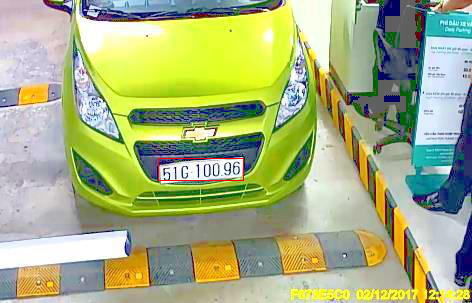

In [359]:
image_lst_train[1000]

In [355]:
image_lst_test = draw_bounding_box(img_test, obj_test)

 Processing images:   0%|          | 0/882 [00:00<?, ?it/s]

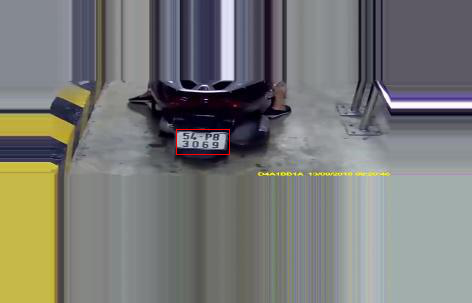

In [356]:
image_lst_test[750]

### Preprocessing data

In [360]:
from transformers import AutoImageProcessor

checkpoint = "facebook/detr-resnet-50"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

c:\Users\fSIoF\anaconda3\envs\pytorch_venv\Lib\site-packages\huggingface_hub\file_download.py:137: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\fSIoF\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the 

In [396]:
import albumentations

transform = albumentations.Compose(
    [
        albumentations.Resize(600, 600),
        albumentations.HorizontalFlip(p=1.0),
        albumentations.RandomBrightnessContrast(p=1.0),
    ],
    bbox_params=albumentations.BboxParams(format="coco", label_fields=['category']),
)

In [379]:
def formated_annotations(lst_img_id, lst_bounding_box):
    lst_annotations = []
    for  img_id, bounding_box in zip(lst_img_id, lst_bounding_box):
        new_annot = {
            "image_id" : img_id,
            "bbox" : bounding_box
        }
        lst_annotations.append(new_annot)
    return lst_annotations

In [383]:
lst_formated_ann = formated_annotations(img_id_train, lst_bb_train)
lst_formated_ann

[{'image_id': 1148,
  'bbox': [184.0, 592.0, 131.83999633789062, 63.36000061035156]},
 {'image_id': 892,
  'bbox': [786.0, 387.0, 76.80000305175781, 51.84000015258789]},
 {'image_id': 960,
  'bbox': [867.0, 262.0, 63.333377838134766, 27.346637725830078]},
 {'image_id': 5765,
  'bbox': [398.0, 689.0, 108.16000366210938, 24.340036392211914]},
 {'image_id': 2407,
  'bbox': [262.0, 590.0, 58.880001068115234, 14.089715957641602]},
 {'image_id': 5588,
  'bbox': [245.0, 785.0, 191.57330322265625, 40.31999969482422]},
 {'image_id': 1892,
  'bbox': [823.0, 551.0, 92.16000366210938, 86.45773315429688]},
 {'image_id': 2945,
  'bbox': [345.0, 493.0, 138.24000549316406, 41.00595474243164]},
 {'image_id': 4782,
  'bbox': [355.0, 435.0, 189.44000244140625, 81.92498016357422]},
 {'image_id': 1412,
  'bbox': [156.0, 358.0, 47.36000061035156, 19.850149154663086]},
 {'image_id': 1884,
  'bbox': [369.0, 338.0, 337.2799987792969, 150.39974975585938]},
 {'image_id': 2203,
  'bbox': [632.0, 382.0, 131.839996

In [391]:
#Transforming batch
def transforn_aug_ann(lst_img, lst_img_ids, lst_formatted_anns):
    images, bboxes, = [], []
    for image, object in zip(lst_img, lst_formatted_anns):
        image = np.array(image.convert("RGB"))[:, :, ::-1]
        out = transform(image = image, bboxes = object['bbox'] )
        images.append(out["image"])
        bboxes.append(out["bboxes"])
    targets = [

        {"image_id": id_, "annotations": lst_formatted_anns(id_, box_)}

        for id_, box_ in zip(lst_img_ids, bboxes)
    ]

    return image_processor(images=images, annotations=targets, return_tensors="pt")
    

In [397]:
transforn_aug_ann(image_lst_train, img_id_train, lst_formated_ann)

TypeError: object of type 'float' has no len()

### Resnet Architecture

In [ ]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.IMAGENET1K_V1
transforms = weights.transforms()